In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import re

In [2]:
GAMMAS = ['1.0','0.9','0.8','0.7','0.6','0.5']
INDEX_TIME_UNIT = 1000 # number of tweets
QUERY_TIME_UNIT = 1000 # number of tweets
SIMILARITY_THRE = 0.5
NUMBER_OF_RUNS = 3
OUTPUT_DIR = "./output_expm1/n7/"

def get_chance(gamma):
    if gamma == '1.0':
        return '100'
    elif gamma == '0.9':
        return '90'
    elif gamma == '0.8':
        return '80'
    elif gamma == '0.7':
        return '70'
    elif gamma == '0.6':
        return '60'
    elif gamma == '0.5':
        return '50'
    
def get_gamma_index(gamma):
    if gamma == '1.0':
        return 0
    elif gamma == '0.9':
        return 1
    elif gamma == '0.8':
        return 2
    elif gamma == '0.7':
        return 3
    elif gamma == '0.6':
        return 4
    elif gamma == '0.5':
        return 5
    
SUMMARY_INDEX = pd.Index(['Run', 'Chance', 'Index time unit', 'Query time unit', 'Similarity threshold', 
                 'Query counts', 'Indexed tweet counts', 'Index size'])
SUMMARY_COL = ['Summary_' + get_chance(p) + '%' for p in GAMMAS]
QUERY_RESULT_COL = ['Result_' + get_chance(p) + '%' for p in GAMMAS]
QUERY_SIMILARITY_COL = ['Similarity_' + get_chance(p) + '%' for p in GAMMAS]
QUERY_LOOKUPS_COL = ['Lookups_' + get_chance(p) + '%' for p in GAMMAS]
INDEX_TIME_COL = ['Index_time_run{}_{}%'.format(str(i+1), get_chance(p)) for p in GAMMAS for i in range(NUMBER_OF_RUNS)]
QUERY_TIME_COL = ['Query_time_run{}_{}%'.format(str(i+1), get_chance(p)) for p in GAMMAS for i in range(NUMBER_OF_RUNS)]

FREQ_TABLES_X = ['Posting_list_length_' + get_chance(p) + '%' for p in GAMMAS]
QUERY_RECALL_X = ['Query_recall_' + get_chance(p) + '%' for p in GAMMAS]
QUERY_PRECISION_X = ['Query_precision_' + get_chance(p) + '%' for p in GAMMAS]
QUERY_LESS_LOOKUPS_X = ['Query_of_less_lookups_' + get_chance(p) + '%' for p in GAMMAS]
AVERAGE_LOOKUPS_X = ['Average_lookup_counts_' + get_chance(p) + '%' for p in GAMMAS]
PLOT_X = [get_chance(p) + '%' for p in GAMMAS]

# Run Experiment  One and Read in Results

* Use single terms to construct index
* Each term has a 100% chance to 50% chance to be included in the index or fingerprint

In [3]:
def runSketchTweets(jar, index_time_unit, query_time_unit, chance_gamma, similarity_threshold, n, output_dir):
    for run in range (1, n+1):
        os.system("java -jar ./{}.jar -iu {} -qu {} -p {} -s {} -n {} -o {}"
        .format(jar, index_time_unit, query_time_unit, chance_gamma, similarity_threshold, run, output_dir))
        print("java -jar ./{}.jar -iu {} -qu {} -p {} -s {} -n {} -o {}"
        .format(jar, index_time_unit, query_time_unit, chance_gamma, similarity_threshold, run, output_dir))

In [4]:
# This function runs the experiment and compares the results including:
# - the size of the index and doc lists 
# - time for constructing the index and executing query 
# - number of lookups before finding the match

def run_expm1():
    for p in GAMMAS:
        runSketchTweets("SketchingTweet-v1_n7", INDEX_TIME_UNIT, QUERY_TIME_UNIT, p, SIMILARITY_THRE, NUMBER_OF_RUNS, OUTPUT_DIR)
    results = load_expm1_csv(OUTPUT_DIR)
    return results

In [5]:
def load_expm1_csv(directory):
    '''
    Returns a dictionary of results.
    The dictionary keys are: summary, termfreq, query_results_similarity_lookups, index_time, query_time
    '''
    results = {}
    summary = [0] * len(GAMMAS)
    termfreq = [0] * len(GAMMAS)
    query_result = [0] * len(GAMMAS)
    query_similarity = [0] * len(GAMMAS)
    query_lookups = [0] * len(GAMMAS)
    index_time = [[0 for j in range(NUMBER_OF_RUNS)] for i in range(len(GAMMAS))]
    query_time = [[0 for j in range(NUMBER_OF_RUNS)] for i in range(len(GAMMAS))]
      

    for root, _, files in os.walk(directory):
        for file in files:
            filename = re.match( r'Epoch_(\d+)_iu_(\d+)_qu_(\d+)_p_(\d+\.\d+)_s_([\.\d]+)_(.+).csv', file)  
#             print(filename.group(3),filename.group(4),filename.group(5),filename.group(6))
            name = filename.group(6)
            gamma = filename.group(4)

            if name == "summary":    
                for p in GAMMAS:
                    if gamma == p:
                        summary[get_gamma_index(gamma)] = pd.read_csv(directory + "/" + file, header=None)

            if name == "term_freq":
                for p in GAMMAS:
                    if gamma == p:
                        termfreq[get_gamma_index(gamma)] = pd.read_csv(directory + "/" + file, header=None)
                    
            if name == "query_result":
                for p in GAMMAS:
                    if gamma == p:
                        query_result[get_gamma_index(gamma)] = pd.read_csv(directory + "/" + file, header=None)
                    
            if name == "query_similarity":
                for p in GAMMAS:
                    if gamma == p:
                        query_similarity[get_gamma_index(gamma)] = pd.read_csv(directory + "/" + file, header=None)
                    
            if name == "lookups":
                for p in GAMMAS:
                    if gamma == p:
                        query_lookups[get_gamma_index(gamma)] = pd.read_csv(directory + "/" + file, header=None)
            
            if name == "index_time":
                run = filename.group(1)
                for p in GAMMAS:
                    if gamma == p:
                        for i in range(0,NUMBER_OF_RUNS):
                            if run == str(i+1):
                                index_time[get_gamma_index(gamma)][i] = pd.read_csv(directory + "/" + file, header=None)
                    
            if name == "query_time":
                run = filename.group(1)
                for p in GAMMAS:
                    if gamma == p:
                        for i in range(0,NUMBER_OF_RUNS):
                            if run == str(i+1):
                                query_time[get_gamma_index(gamma)][i] = pd.read_csv(directory + "/" + file, header=None)
                  
    
    summary = pd.concat(summary, 1)
    summary = summary.set_index(SUMMARY_INDEX)
    summary.columns = SUMMARY_COL
#     print(summary)
    
    for table in termfreq:
        termfreq_index = table.iloc[:,0]
        table.set_index(termfreq_index, inplace=True)
        table.drop(table.columns[0], axis=1, inplace=True)
        table.columns = ['number_of_terms', 'posting_count']
#     print(termfreq)
    
    query_result = pd.concat(query_result, 1)
    query_result.columns = QUERY_RESULT_COL
#     print(query_result)
    
    query_similarity = pd.concat(query_similarity, 1)
    query_similarity.columns = QUERY_SIMILARITY_COL
#     print(query_similarity)

    query_lookups = pd.concat(query_lookups, 1)
    query_lookups.columns = QUERY_LOOKUPS_COL
#     print(query_lookups)

    query_result_similarity_lookup = [query_result, query_similarity, query_lookups]
    query_result_similarity_lookup = pd.concat(query_result_similarity_lookup, 1)
#     print(query_result_similarity_lookup)
    
    index_time_dfs = []
    for p in index_time:
        index_time_df = pd.concat(p, 1)
        index_time_dfs.append(index_time_df)
    index_time = pd.concat(index_time_dfs, 1)
    index_time.columns = INDEX_TIME_COL
    
    query_time_dfs = []
    for p in query_time:
        query_time_df = pd.concat(p, 1)
        query_time_dfs.append(query_time_df)
    query_time = pd.concat(query_time_dfs, 1)
    query_time.columns = QUERY_TIME_COL
    
    results['summary'] = summary
    results['termfreq'] = termfreq
    results['query_result_similarity_lookup'] = query_result_similarity_lookup
    results['index_time'] = index_time
    results['query_time'] = query_time
  
    return results

In [6]:
results = run_expm1() 

# Process Results

In [7]:
def plot_linechart(title, x, y, x_label, y_label, scale='linear'):
    plt.plot(x, y)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.yscale(scale)
    plt.show()
    
def plot_scatter(title, x, y, x_label, y_label, scale='linear'):
    plt.scatter(x, y, s=0.5)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.yscale(scale)
    plt.show()
    
def plot_barchart(title, x, y, x_label, y_label, color="#66B3BA"):
    layer = sns.barplot(x=x, y=y, color=color)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()
    
def plot_boxplot(title, data, y_label, scale='linear'):
    layer = sns.boxplot(data=data)
    layer = sns.stripplot(data=data, color="orange", jitter=0.2, size=1.5)
    plt.title(title)
    plt.ylabel(y_label)
    plt.yscale(scale)
    plt.show()

## Index size comparison

In [8]:
summary = results['summary']
summary

,Summary_100%,Summary_90%,Summary_80%,Summary_70%,Summary_60%,Summary_50%
Run,1,1,1,1,1,1
Chance,100.0%,90.0%,80.0%,70.0%,60.0%,50.0%
Index time unit,1000,1000,1000,1000,1000,1000
Query time unit,1000,1000,1000,1000,1000,1000
Similarity threshold,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
Query counts,21890,21890,21890,21890,21890,21890
Indexed tweet counts,197610,197610,197610,197610,197610,197610
Index size,215201,174265,160477,144645,126811,107534


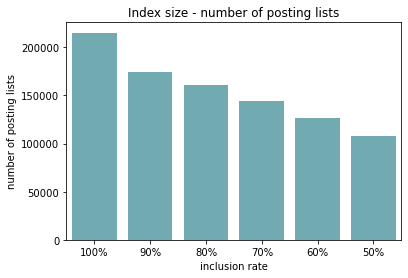

Summary_100%    215201
Summary_90%     174265
Summary_80%     160477
Summary_70%     144645
Summary_60%     126811
Summary_50%     107534
Name: Index size, dtype: object

In [9]:
# index size - number of posting lists
def compare_index_size(sizes, title):
    data = pd.to_numeric(sizes).to_list()
    plot_barchart(title, PLOT_X, data, 'inclusion rate', 'number of posting lists')

compare_index_size(summary.loc['Index size'], "Index size - number of posting lists")
summary.loc['Index size']

## Documnet list length comparison

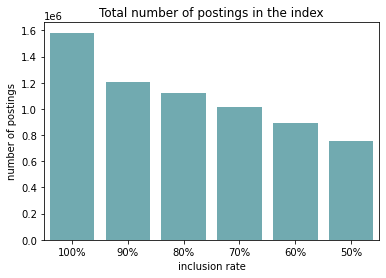

Total number of postings:


[1582263, 1204963, 1122935, 1018195, 893204, 755850]

In [10]:
freq_tables = results['termfreq']
posting_list_length_distribution = [table['posting_count'].value_counts().sort_index(inplace=False) for table in freq_tables]
total_posting_counts = [sum(table['posting_count']) for table in freq_tables]
plot_barchart('Total number of postings in the index', PLOT_X, total_posting_counts, 'inclusion rate', 'number of postings')
print('Total number of postings:')
total_posting_counts

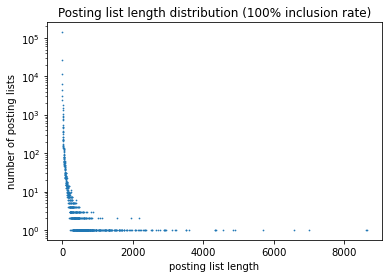

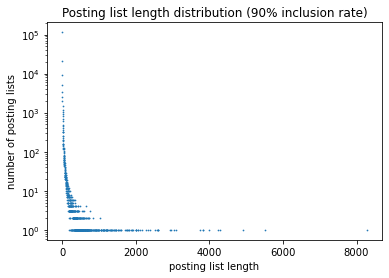

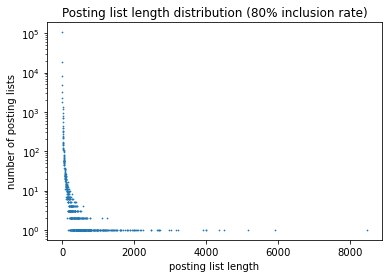

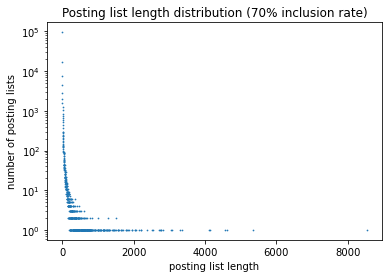

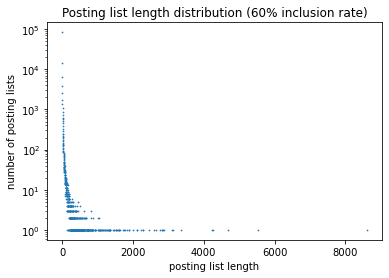

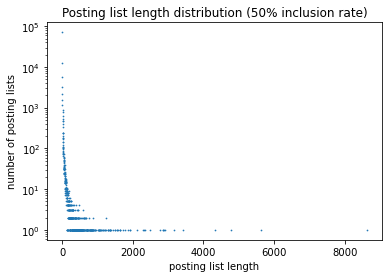

In [11]:
def compare_postinglist_length_distribution(PLOT_X, posting_list_length_distribution):
    for i in range(len(PLOT_X)):
        title = f'Posting list length distribution ({PLOT_X[i]} inclusion rate)'
        x = posting_list_length_distribution[i].index
        y = posting_list_length_distribution[i]
        plot_scatter(title, x, y, 'posting list length', 'number of posting lists', scale='log')   
compare_postinglist_length_distribution(PLOT_X, posting_list_length_distribution)

Average posting list length
[7.352489068359348, 6.914543941697989, 6.9974825052811305, 7.039268554046113, 7.043584547081878, 7.028939684192906]


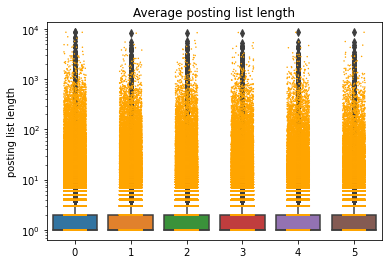

In [12]:
def compare_posting_list_len(PLOT_X, freq_tables):
    lengths = [table['posting_count'] for table in freq_tables]
    avgs = [sum(l)/len(l) for l in lengths]
    print("Average posting list length")
    print(avgs)
#     index15 = [int(round(len(l)*0.15,0)) for l in lengths]
#     index85 = [int(round(len(l)*0.85,0)) for l in lengths]
#     nooutlier_lengths = [ lengths[i][index15[i]:index85[i]] for i in range(len(lengths))]
    plot_boxplot(f'Average posting list length', lengths, 'posting list length', scale='log')
    
compare_posting_list_len(PLOT_X, freq_tables)

## Query Recall

In [13]:
query_result_similarity_lookup = results['query_result_similarity_lookup']
query_result_similarity_lookup

,Result_100%,Result_90%,Result_80%,Result_70%,Result_60%,Result_50%,Similarity_100%,Similarity_90%,Similarity_80%,Similarity_70%,Similarity_60%,Similarity_50%,Lookups_100%,Lookups_90%,Lookups_80%,Lookups_70%,Lookups_60%,Lookups_50%
0,189567,-1,189567,26531,189567,189567,0.63636,0.00000,0.71429,0.85714,0.66667,0.60000,5137,-1,2506,54663,1410,635
1,146028,146028,146028,111571,197559,191639,0.50000,0.50000,0.50000,0.66667,0.50000,1.00000,6516,3812,3912,5208,2,1
2,-1,-1,-1,145908,145908,145908,0.00000,0.00000,0.00000,0.50000,0.60000,0.50000,-1,-1,-1,1542,1240,172
3,-1,-1,-1,-1,-1,185838,0.00000,0.00000,0.00000,0.00000,0.00000,0.50000,-1,-1,-1,-1,-1,2
4,-1,-1,-1,-1,-1,157608,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,-1,-1,-1,-1,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21885,-1,-1,-1,-1,196841,196841,0.00000,0.00000,0.00000,0.00000,0.50000,0.50000,-1,-1,-1,-1,2,2
21886,-1,-1,-1,-1,-1,-1,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-1,-1,-1,-1,-1,-1
21887,-1,-1,-1,-1,-1,197608,0.00000,0.00000,0.00000,0.00000,0.00000,0.50000,-1,-1,-1,-1,-1,2
21888,-1,-1,-1,-1,-1,195394,0.00000,0.00000,0.00000,0.00000,0.00000,0.50000,-1,-1,-1,-1,-1,324


In [14]:
has_true_similar = query_result_similarity_lookup[QUERY_RESULT_COL[0]] != -1
true_similar = query_result_similarity_lookup[has_true_similar]
num_true_similar = true_similar.shape[0]
true_similar

,Result_100%,Result_90%,Result_80%,Result_70%,Result_60%,Result_50%,Similarity_100%,Similarity_90%,Similarity_80%,Similarity_70%,Similarity_60%,Similarity_50%,Lookups_100%,Lookups_90%,Lookups_80%,Lookups_70%,Lookups_60%,Lookups_50%
0,189567,-1,189567,26531,189567,189567,0.63636,0.00000,0.71429,0.85714,0.66667,0.60000,5137,-1,2506,54663,1410,635
1,146028,146028,146028,111571,197559,191639,0.50000,0.50000,0.50000,0.66667,0.50000,1.00000,6516,3812,3912,5208,2,1
8,44802,44802,197071,197071,197071,197071,0.60000,0.60000,0.50000,0.50000,0.50000,0.66667,38975,34625,60,60,56,42
12,170152,193999,193999,197505,197505,197505,0.60000,0.50000,0.50000,0.50000,0.50000,0.50000,7605,316,336,2,2,2
15,102434,102434,187662,168323,187662,187662,0.50000,0.50000,0.50000,0.66667,0.66667,0.66667,10200,8892,308,570,213,216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21878,197554,197554,197554,197554,197554,197554,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,7,7,6,6,5,4
21880,197554,197554,197554,197554,197554,197554,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,7,7,6,6,5,4
21881,93654,-1,-1,-1,93654,-1,0.53846,0.00000,0.00000,0.00000,0.57143,0.00000,81484,-1,-1,-1,34930,-1
21884,178680,178680,178680,178680,178680,178680,0.62500,0.71429,0.71429,0.66667,0.66667,0.66667,120,77,77,66,66,66


In [15]:
num_correct_searches = []
correct_searches = []
for i in range(len(QUERY_RESULT_COL)):
    is_correct_search = true_similar[QUERY_RESULT_COL[0]] == true_similar[QUERY_RESULT_COL[i]]
    correct_search = true_similar[is_correct_search]
    correct_searches.append(correct_search)
    num_correct_searches.append(correct_search.shape[0])
print('Number of true similar tweets that we found: ')
num_correct_searches

Number of true similar tweets that we found: 


[7247, 4303, 3962, 3515, 2938, 2225]

Using 100% of terms, we can find 100.0% truly similar tweets
Using 90% of terms, we can find 59.38% truly similar tweets
Using 80% of terms, we can find 54.67% truly similar tweets
Using 70% of terms, we can find 48.5% truly similar tweets
Using 60% of terms, we can find 40.54% truly similar tweets
Using 50% of terms, we can find 30.7% truly similar tweets


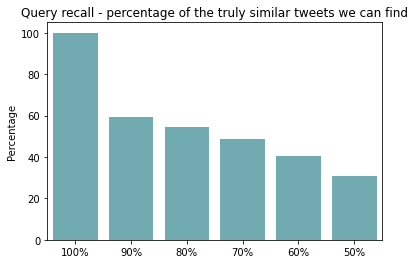

In [16]:
def compare_query_recall(recalls, title): 
    layer = sns.barplot(x=PLOT_X, y=recalls, color="#66B3BA")
    plt.title(title)
    layer.set(ylabel='Percentage')
    plt.show()

recalls = []
true_searches = []
for i in range(len(num_correct_searches)):
    true_searches.append(num_correct_searches[i])
    recall = round((num_correct_searches[i]/num_true_similar) * 100, 2)
    recalls.append(recall)
    chance = PLOT_X[i]
    print('Using {} of terms, we can find {}% truly similar tweets'.format(chance, recall))
    
compare_query_recall(recalls, 'Query recall - percentage of the truly similar tweets we can find')

## Query Precision

In [17]:
# is_predict_similar = query_result_similarity_lookup['Result_75%'] != -1
# predict_similar = query_result_similarity_lookup[is_predict_similar]
# num_predict_similar = predict_similar.shape[0]
# predict_similar
num_predict_similar_lst = []
predict_similar_lst = []
for i in range(len(QUERY_RESULT_COL)):
    is_predict_similar = query_result_similarity_lookup[QUERY_RESULT_COL[i]] != -1
    predict_similar = query_result_similarity_lookup[is_predict_similar]
    predict_similar_lst.append(predict_similar)
    num_predict_similar_lst.append(predict_similar.shape[0])
print("The number of tweets that we think are similar: ")
num_predict_similar_lst

The number of tweets that we think are similar: 


[7247, 7544, 8858, 10411, 12223, 13880]

Using 100% of terms, 100.0% tweets that we found similar are truly similar tweets
Using 90% of terms, 57.04% tweets that we found similar are truly similar tweets
Using 80% of terms, 44.73% tweets that we found similar are truly similar tweets
Using 70% of terms, 33.76% tweets that we found similar are truly similar tweets
Using 60% of terms, 24.04% tweets that we found similar are truly similar tweets
Using 50% of terms, 16.03% tweets that we found similar are truly similar tweets


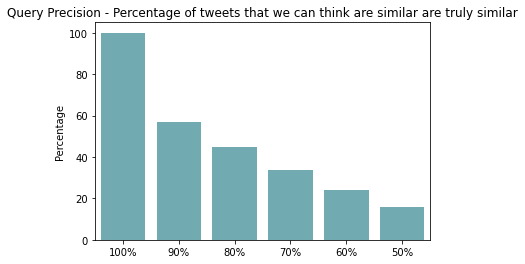

In [18]:
def compare_query_precision(precisions, title): 
    layer = sns.barplot(x=PLOT_X, y=precisions, color="#66B3BA")
    layer.set(ylabel='Percentage')
    plt.title(title)
    plt.show()

precisions = []
for i in range(len(num_predict_similar_lst)):
    precision = round((num_correct_searches[i]/num_predict_similar_lst[i]) * 100, 2)
    precisions.append(precision)
    chance = PLOT_X[i]
    print('Using {} of terms, {}% tweets that we found similar are truly similar tweets'.format(chance, precision))
    
compare_query_precision(precisions, 'Query Precision - Percentage of tweets that we can think are similar are truly similar')

## Number of searches that need fewer lookups

In [19]:
correct_search

,Result_100%,Result_90%,Result_80%,Result_70%,Result_60%,Result_50%,Similarity_100%,Similarity_90%,Similarity_80%,Similarity_70%,Similarity_60%,Similarity_50%,Lookups_100%,Lookups_90%,Lookups_80%,Lookups_70%,Lookups_60%,Lookups_50%
0,189567,-1,189567,26531,189567,189567,0.63636,0.00000,0.71429,0.85714,0.66667,0.60000,5137,-1,2506,54663,1410,635
18,196085,196085,196085,197415,197415,196085,0.80000,0.80000,0.80000,0.50000,0.50000,0.66667,255,215,235,12,12,114
45,196644,196644,196644,196644,196644,196644,0.80000,0.66667,0.50000,0.50000,0.50000,0.50000,35,21,2,2,2,2
55,196844,174964,196844,24961,196844,196844,0.85714,0.57143,0.71429,0.57143,0.85714,0.71429,224,1561,105,4466,105,105
73,34300,34300,34300,34300,34300,34300,1.00000,1.00000,0.85714,0.85714,1.00000,1.00000,30897,14427,12887,17066,14014,14217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21875,197554,197554,197554,197554,197554,197554,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,7,7,6,6,5,4
21878,197554,197554,197554,197554,197554,197554,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,7,7,6,6,5,4
21880,197554,197554,197554,197554,197554,197554,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,7,7,6,6,5,4
21884,178680,178680,178680,178680,178680,178680,0.62500,0.71429,0.71429,0.66667,0.66667,0.66667,120,77,77,66,66,66


In [20]:
query_of_less_lookups = []
less_search_lst = []
for i in range(len(QUERY_LOOKUPS_COL)):
    if i != 0:
        is_less_search = correct_searches[i][QUERY_LOOKUPS_COL[0]] > correct_searches[i][QUERY_LOOKUPS_COL[i]]
        less_search = correct_searches[i][is_less_search]
        less_search_lst.append(less_search)
        query_of_less_lookups.append(less_search.shape[0])
    else:
        less_search_lst.append(None)
        query_of_less_lookups.append(0)
print("The number of tweets that need less lookups before correctly finding the true similar tweets: ")
query_of_less_lookups

The number of tweets that need less lookups before correctly finding the true similar tweets: 


[0, 4255, 3935, 3496, 2915, 2214]

Using 100% of terms, 0.0% queries need less lookups before correctly finding the true similar tweets
Using 90% of terms, 98.88% queries need less lookups before correctly finding the true similar tweets
Using 80% of terms, 99.32% queries need less lookups before correctly finding the true similar tweets
Using 70% of terms, 99.46% queries need less lookups before correctly finding the true similar tweets
Using 60% of terms, 99.22% queries need less lookups before correctly finding the true similar tweets
Using 50% of terms, 99.51% queries need less lookups before correctly finding the true similar tweets


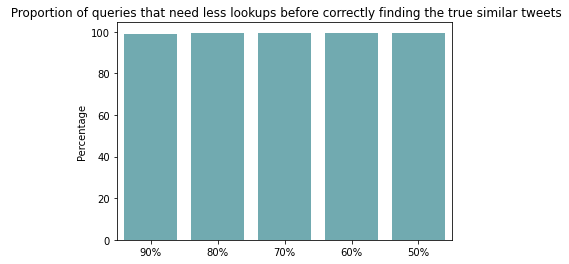

In [21]:
def compare_number_of_tweets_need_less_lookups(reduces, title): 
    layer = sns.barplot(x=PLOT_X[1:], y=reduces, color="#66B3BA")
    layer.set(ylabel='Percentage')
    plt.title(title)
    plt.show()

proportions = []
for i in range(len(query_of_less_lookups)):
    proportion = round((query_of_less_lookups[i] / num_correct_searches[i]) * 100, 2)
    proportions.append(proportion)
    chance = PLOT_X[i]
    print('Using {} of terms, {}% queries need less lookups before correctly finding the true similar tweets'.format(chance, proportion))
    
compare_number_of_tweets_need_less_lookups(proportions[1:], ' Proportion of queries that need less lookups before correctly finding the true similar tweets')

## Number of average lookups

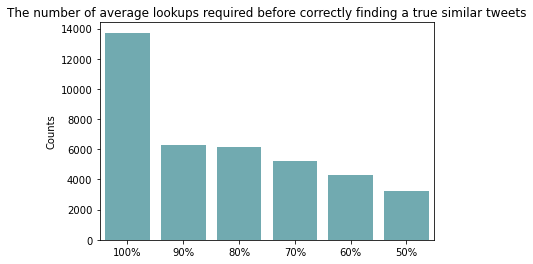

In [22]:
def compare_number_of_avg_lookups(reduces, title): 
    layer = sns.barplot(x=PLOT_X, y=reduces, color="#66B3BA")
    layer.set(ylabel='Counts')
    plt.title(title)
    plt.show()

avg_lookups = []
for i in range(len(QUERY_LOOKUPS_COL)):
    avg_lookup = np.average(np.array(correct_searches[i][QUERY_LOOKUPS_COL[i]]))
    avg_lookups.append(avg_lookup)

compare_number_of_avg_lookups(avg_lookups, 'The number of average lookups required before correctly finding a true similar tweets')

In [23]:
reduces = []
print('Comparing to using all the terms:')
for i in range(len(avg_lookups)):
    if i != 0:
        reduce = round(((avg_lookups[0] - avg_lookups[i]) / avg_lookups[0]) * 100, 2)
        reduces.append(reduce)
        chance = PLOT_X[i]
        print('By using {} of terms, {}% of less lookups are needed for correctly finding a true similar tweets'.format(chance, reduce))

Comparing to using all the terms:
By using 90% of terms, 54.09% of less lookups are needed for correctly finding a true similar tweets
By using 80% of terms, 55.16% of less lookups are needed for correctly finding a true similar tweets
By using 70% of terms, 62.01% of less lookups are needed for correctly finding a true similar tweets
By using 60% of terms, 68.75% of less lookups are needed for correctly finding a true similar tweets
By using 50% of terms, 76.43% of less lookups are needed for correctly finding a true similar tweets


## Index time comparison

In [24]:
index_time = results['index_time']
index_time

,Index_time_run1_100%,Index_time_run2_100%,Index_time_run3_100%,Index_time_run1_90%,Index_time_run2_90%,Index_time_run3_90%,Index_time_run1_80%,Index_time_run2_80%,Index_time_run3_80%,Index_time_run1_70%,Index_time_run2_70%,Index_time_run3_70%,Index_time_run1_60%,Index_time_run2_60%,Index_time_run3_60%,Index_time_run1_50%,Index_time_run2_50%,Index_time_run3_50%
0,13.3292,11.8724,12.0992,17.9396,15.1500,16.4672,15.6195,25.3224,16.5287,15.2931,16.0190,16.1312,24.8114,25.2121,20.5133,18.2627,20.5664,16.6076
1,6.2474,5.8399,5.0330,6.5618,6.1499,6.3221,7.7873,9.8187,8.3436,6.2458,6.2445,7.1585,11.5968,10.0752,6.8645,6.9595,6.4567,7.2537
2,5.6787,6.1824,4.7535,5.5937,5.6841,6.5197,8.1035,9.7699,7.7201,5.9906,5.9635,6.7948,11.4572,8.5840,8.6464,7.0785,8.5493,6.9719
3,4.9619,6.0191,4.7911,5.1773,5.2129,5.7442,7.4497,8.3756,7.3516,5.4410,5.4473,5.8221,10.9655,7.0829,6.5741,5.6455,5.7690,6.6656
4,5.6062,5.6903,4.6464,5.0293,5.4309,5.8128,7.4426,8.6895,6.8666,7.2114,5.1928,5.1790,11.1273,7.0383,7.5603,5.9110,5.9770,7.0487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,2.6472,2.7346,1.9707,3.0407,3.1646,3.1760,3.7486,4.3177,4.0057,3.3264,3.0898,4.4409,3.6824,2.5323,2.6520,4.0147,2.7747,3.1973
193,2.5419,2.7379,1.9678,2.9016,3.2256,14.7749,4.1916,4.1672,4.6827,2.5028,3.2375,3.1626,3.2182,3.3300,2.5471,2.9138,3.5299,3.1205
194,2.7347,2.5124,1.9389,2.9921,3.4199,2.8892,5.7204,4.1725,4.9888,2.5073,3.2028,3.0871,4.6666,3.0994,2.6838,3.3216,2.6651,3.2640
195,2.5029,2.5285,1.7865,2.8651,2.9931,2.5889,3.7341,4.0422,5.1454,12.8650,3.1107,4.2135,4.1526,3.0052,2.5376,3.1519,2.5738,3.2217


By using 100% of terms, the average time for indexing 1000 tweets is 3.2061 milliseconds
By using 90% of terms, the average time for indexing 1000 tweets is 3.4647 milliseconds
By using 80% of terms, the average time for indexing 1000 tweets is 4.5614 milliseconds
By using 70% of terms, the average time for indexing 1000 tweets is 3.9547 milliseconds
By using 60% of terms, the average time for indexing 1000 tweets is 4.3447 milliseconds
By using 50% of terms, the average time for indexing 1000 tweets is 3.7722 milliseconds


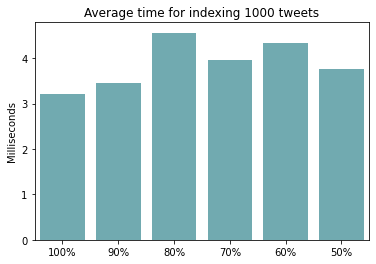

In [25]:
def compare_time(avg_time, title): 
    layer = sns.barplot(x=PLOT_X, y=avg_time, color="#66B3BA")
    layer.set(ylabel='Milliseconds')
    plt.title(title)
    plt.show()

index_time_avgs = []
for col in index_time.columns:
    index_time_avgs.append(np.average(np.array(index_time[col])))

index_time_avgs2 = []
c = 0
acc = 0
for avg in index_time_avgs:
    if c < 2:
        acc += avg
        c += 1
        
    else:
        acc += avg
#         print(acc)
        index_time_avgs2.append(round(acc/3 , 4))
        acc = 0
        c = 0

for i in range(len(index_time_avgs2)):
    print('By using {} of terms, the average time for indexing {} tweets is {} milliseconds'.format(PLOT_X[i], INDEX_TIME_UNIT, index_time_avgs2[i]))
compare_time(index_time_avgs2, 'Average time for indexing {} tweets'.format(INDEX_TIME_UNIT))

## Query time comparison

In [26]:
query_time = results['query_time']
query_time

,Query_time_run1_100%,Query_time_run2_100%,Query_time_run3_100%,Query_time_run1_90%,Query_time_run2_90%,Query_time_run3_90%,Query_time_run1_80%,Query_time_run2_80%,Query_time_run3_80%,Query_time_run1_70%,Query_time_run2_70%,Query_time_run3_70%,Query_time_run1_60%,Query_time_run2_60%,Query_time_run3_60%,Query_time_run1_50%,Query_time_run2_50%,Query_time_run3_50%
0,2.9377,2.5818,2.2668,6.5892,12.4494,1.7658,2.4103,12.0843,11.8972,12.3489,3.2436,2.7704,1.9269,2.8819,2.7133,2.0962,2.2766,1.5947
1,299.9678,298.3265,285.5396,174.2430,233.6773,203.0879,298.2868,273.9504,183.6966,161.0482,163.6908,304.1305,179.2596,182.0885,155.5184,151.6603,137.8974,182.3913
2,192.3665,186.9032,182.9138,83.7322,98.5681,87.1235,120.7131,181.5126,103.6966,58.8128,67.8930,127.9815,84.0762,62.1488,61.8604,34.3808,32.8817,30.8933
3,194.1688,196.0727,192.2555,91.2240,95.4888,88.8255,101.7204,172.7319,103.6139,64.4634,71.9973,109.3404,80.6661,74.5849,68.8014,37.8860,36.4643,37.4632
4,197.4700,204.3050,194.9410,91.2300,91.2499,91.5060,122.5355,168.0749,102.4095,66.7585,69.7374,91.2693,81.0555,61.5854,71.1579,35.6655,34.3723,31.1049
5,187.4534,191.2204,175.4462,91.7022,93.3763,104.0004,183.5008,195.5781,103.8837,68.1943,68.8801,91.8146,74.1068,68.3484,70.5604,35.4205,35.5565,33.2154
6,187.1597,189.6520,177.0540,87.0436,93.8741,111.0264,128.1878,191.2866,94.8433,63.6181,68.3526,97.7433,67.1846,69.5066,60.1077,36.3731,32.6151,30.5447
7,195.2349,205.2552,187.8437,98.5871,106.7339,113.1721,112.9751,134.4814,103.7643,69.9224,74.5481,79.9593,145.5335,77.4773,72.4259,41.3055,40.3215,45.4817
8,196.9690,200.0381,209.3793,97.0452,98.0200,102.7427,182.7297,164.4315,98.7890,66.7323,71.9196,78.4873,117.3224,67.0630,60.2153,35.8572,34.1101,35.8677
9,180.3557,176.1789,191.8276,87.1732,88.1767,91.9840,151.1768,119.0575,93.3151,59.9566,64.7159,68.5180,114.2752,62.6013,54.2196,36.8365,33.2629,32.6620


By using 100% of terms, the average time for querying 1000 tweets is 178.3347 milliseconds
By using 90% of terms, the average time for querying 1000 tweets is 89.7849 milliseconds
By using 80% of terms, the average time for querying 1000 tweets is 120.4741 milliseconds
By using 70% of terms, the average time for querying 1000 tweets is 73.8612 milliseconds
By using 60% of terms, the average time for querying 1000 tweets is 76.2672 milliseconds
By using 50% of terms, the average time for querying 1000 tweets is 37.8073 milliseconds


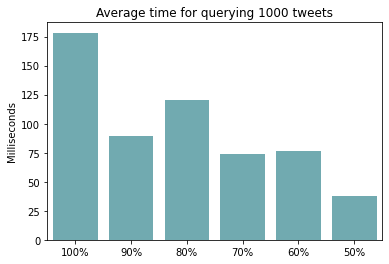

In [27]:
query_time_avgs = []
for col in query_time.columns:
    query_time_avgs.append(np.average(np.array(query_time[col])))

query_time_avgs2 = []
c = 0
acc = 0
for avg in query_time_avgs:
    if c < 2:
        acc += avg
        c += 1
        
    else:
        acc += avg
#         print(acc)
        query_time_avgs2.append(round(acc/3 , 4))
        acc = 0
        c = 0

for i in range(len(query_time_avgs2)):
    print('By using {} of terms, the average time for querying {} tweets is {} milliseconds'.format(PLOT_X[i], INDEX_TIME_UNIT, query_time_avgs2[i]))
compare_time(query_time_avgs2, 'Average time for querying {} tweets'.format(INDEX_TIME_UNIT))